<a href="https://colab.research.google.com/github/ThomasHeap/Examples/blob/main/M2L_summer_school/GNN/introduction_to_gnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Graph Neural Networks (GNNs) Architectures.
---

## Tutorial Overview
In this tutorial you will get familiar with Graph Neural Networks (GNNs) by implementing two basic GNNs architectures from scratch: GCN and GAT. You will then train and evaluate these models on the Cora node classification task, and compare their results to a non-relational MLP baseline.


## Outline

1. Theory Recap
2. Task 1: Graph Convolution Network (GCN) Implementation.
3. Task 2: Graph Attention Network (GAT) Implementation.
4. Task 3: Efficient GAT and GCN implementations with Sparse Matrix operations.
5. Task 4: Node classification on the Cora dataset: training, evaluation & analysis.

**NB**: Throughout the tutorial you'll find a couple of 📝 **TODO** items, which will prompt you to either fill in some code or write down the answer to a question.

## Theory Recap

### Fundamental Graph Concepts
A graph consists of a set of nodes and a set of edges, where edges form connections between nodes.

More formally, a graph is defined as $ G = (V, E)$ where $V$ is the set of vertices / nodes, and $E$ is the set of edges.

In an **undirected** graph, each edge is an unordered pair of two nodes $\in V$. E.g. a friend network can be represented as an undirected graph, assuming that the relationship "*A is friends with B*" implies "*B is friends with A*".

In a **directed** graph, each edge is an ordered pair of nodes $\in V$. E.g. a citation network would be best represented with a directed graph, since the relationship "*A cites B*" does not imply "*B cites A*".

The **degree** of a node is defined as the number of edges incident on it, i.e. the sum of incoming and outgoing edges for that node.

The **in-degree** is the sum of incoming edges only, and the **out-degree** is the sum of outgoing edges only.

There are several ways to represent $E$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|V| \times |V|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|V|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.

---

Example: Below is a directed graph with four nodes and five edges.

<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px"></center>

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$

### Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px"></center>

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?

## Graph Neural Networks (GNNs)

 **Graph Neural Networks (GNNs)** are a class of deep learning models designed to perform tasks on graph-structured data. They operate by propagating information along the edges of the graph, aggregating features from neighboring nodes to generate new node representations. Basic GNNs follow the so-called  **Message Passing (MP) model** which unfolds as follows:


1.   **Initialization**: Every node $u\in \mathcal{V}$, is assigned an initial vector representation $\textbf{h}_u^{(0)} = \textbf{x}_u$.
2.  **Message Passing**: The representation $\mathbf{h}_{u}$ for each node $u \in \mathcal{V}$ is then iteratively updated with the information received from its neighbourhood as:
$$
\mathbf{h}_{u}^{(t)}=\text { update }^{(t)}\left(\mathbf{h}_{u}^{(t-1)}, \text { aggregate }^{(t)}\left(\left\{\mathbf{h}_{v}^{(t-1)} \mid v \in N(u)\right\}\right)\right)
$$
where $\text{aggregate}^{(t)}$ and $\text{update} ^{(t)}$ are arbitrary differentiable functions, and $\text{aggregate} ^{(t)}$ is a permutation-invariant function (e.g. neural networks) e.g. mean, sum, or max. Note that the t-iteration corresponds to the t-layer of the network.

3. **Final representation:** Upon termination, the final node representations will be denoted as $\mathbf{z}_{u}=\mathbf{h}_{u}^{(l)}$.


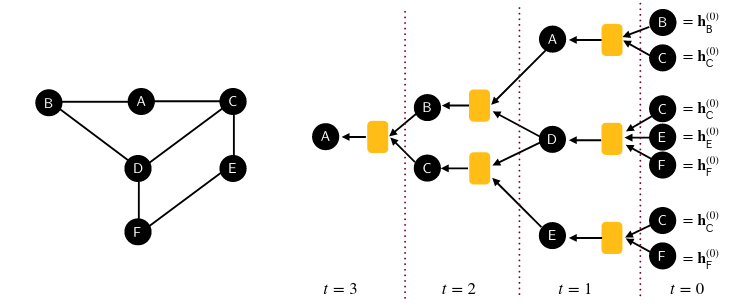


<em style="text-align: center;">Figure 1: The Message Passing model in action. Depiction of how target node $A$ aggregates and combines information its local neighbors. After 3 message passing iterations/layers, the node will have received information from every node in the graph. </em>

In this tutorial, we will focus on two fundamental GNN architectures:

- **Graph Convolution Networks (GCN)**: Introduced by Kipf and Welling (2017), GCNs apply convolutional operations to graph data, capturing localized information in node neighborhoods.
- **Graph Attention Networks (GAT)**: Proposed by Veličković et al. (2018), GATs introduce attention mechanisms to weigh the importance of neighboring nodes during feature aggregation.



## Setup.

Throughout this tutorial we will be using the following librairies.

* [Pytorch Geometric](https://): Pytorch-based library for developing GNNs.
* [Pandas](https://): Python's general purpose data analysis library.
* [Matplotlib](https://): Python's general purpose plotting library.  

The code cell below installs these libraries and define helper functions. You need not to care about these functions for now.

In [1]:
# Install required packages.
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function to get adjacency matrix.
def make_adjacency_matrix(V: int, edge_index: torch.Tensor) -> torch.Tensor:
    # Initialize adjacency matrix A: (V, V)
    A = torch.zeros((V, V), device=x.device)

    # Populate the adjacency matrix
    src, dst = edge_index
    A[src, dst] = 1
    A[dst, src] = 1  # Assuming the graph is undirected
    return A

2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Task 1: Graph Convolution Network (GCN).

The **GCN** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is one of the most simple Graph Neural Network. It applies a convolutional operations to graph data, capturing localized information in node neighborhoods.

A GCN aims to emulate the learning process that a traditional convolutional neural network (CNN) does on images. However, differently from images, the structure of graphs is not constrained to a regular grid, and this prevents the use of traditional convolutional filters.

The regularity of grids reflects two properties that are crucial to applying traditional convolutional filters: (i) pixels are ordered, (ii) pixels have fixed-size neighborhoods (each pixel is surrounded by 8 pixels). Because of these properties, the content of images is *invariant* or *equivariant* to translation (shift operation), allowing the shifting of a local convolutional filter (e.g., 3x3) across the different parts of a larger image (e.g., 64x64). Note that a filter performs a weighted sum aggregation over the inputs (pixels) with learnable weights, where each filter input has its own weight.

In graphs, there is no ordering of nodes, and the edges determine the size of each node neighborhood. Hence, we cannot learn a weighted sum of the neighbors as such weights depend on the neighbors' order that is not present. Instead, we need to apply a learnable filter invariant to the neighbors' order. The simplest solution is to apply the same weight to all neighbors without learning the aggregation function. In other words, each neighbor contributes equally. This type of convolutional filter identifies GCNs that are *isotropic*.


<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_vs_gnn.png" width="400px"></center>

Comparison of CNN and GCN filters.
Image source: https://arxiv.org/pdf/1901.00596.pdf

### Symmetric Normalization
Graph nodes may have different numbers of neighbors/degrees, possibly leading to instabilities during neural network training, e.g., exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$
Note that, with this normalization, we are computing the mean over the neighbors' messages.

Instead, if we want to compute a more dynamic aggregation than the mere mean, we can take into
account both the in and out degrees by computing a *symmetric normalization*, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$

Hence the message passing formula for the GCN is defined as:

$$
H^{(l+1)} = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)
$$

Where $\mathbf{W}^{(l)}$ denotes a layer-specific trainable weight matrix, $\hat{A} = A + I$  is the adjacency matrix augmented with self-loops, $\hat{D}$ is the degree matrix of the graph augmented with self-loops, $H^{(l)}$ is the matrix of the node activations in the $l^{th}$ layer, and $\sigma$ is an activation function such as $\text{ReLu}$.

**📝TODO:** Fill in the code below to complete the GCN module implementation.  
**❗NB:** Do not to apply the $\sigma$ activation as this will be done in the network for all but the last layer.

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(in_channels, out_channels))
        self.out_channels = out_channels

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        # x: (V, d) - Node features matrix
        V = x.size(0)

        # Get adjacency matrix
        A = make_adjacency_matrix(V, edge_index)

        ### YOUR CODE HERE #######################
        # Add self-loops to the adjacency matrix
        A_hat = A + torch.eye(n = A.size()[0])

        # Compute the degree matrix D: (V, V)
        D = torch.diag(torch.sum(A_hat, dim=1))

        # Compute the inverse square root of the degree matrix D^(-1/2): (V, V)
        D_inv_sqrt = torch.linalg.inv(torch.sqrt(D))

        # Compute the normalized adjacency matrix A_hat_norm: (V, V)
        A_hat_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt

        # Perform the GCN (aggregate + update) operation
        # Do not apply the activation function here
        # as it will be done in the network for all but the last layer.
        x = A_hat_norm @ x @ self.W
        ###########################################

        return x

**📝TODO**: Verify the correctness of your GCN module by comparing its output on a the below input to the expected output.

In [9]:
# Check that the GCN output is as expected.
torch.manual_seed(42)
gcn = GCN(in_channels=3, out_channels=2)

# x: (V, d) - Example with 5 nodes and 3-dimensional features
x = torch.rand(5, 3)

# edge_index: (2, E) - Example edges with 4 edges
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])

# H: (V, d') - Output node features matrix after GCN operation
H = gcn(x, edge_index)

# Expected output:
# Shape: (5, 2)
# Value: Tensor([
#   [-0.3225,  0.1145],
#   [-0.2853,  0.1364],
#   [-0.3579,  0.0837],
#   [-0.3847,  0.0366],
#   [-0.4443, -0.0077],
# ])
print(H)

tensor([[-0.3225,  0.1145],
        [-0.2853,  0.1364],
        [-0.3579,  0.0837],
        [-0.3847,  0.0366],
        [-0.4443, -0.0077]], grad_fn=<MmBackward0>)


## Task 2: Graph Attention Network (GAT).


GAT [(Velickovic et al.,  2017)](https://arxiv.org/abs/1710.10903) leverages the attention mechanism [(Bahdanau et al, 2015)](https://arxiv.org/abs/1409.0473) to assign importance to each
neighbor, which is used to weigh this neighbor's influence during the aggregation. While the GCN we covered in the previous section can learn meaningful representations, it suffers from the fact that messages from all its neighbors and the node itself are equally weighted -- well, this is not exactly true because of the symmetric normalization. However, the main limitation is that the aggregation weights are **hard-crafted** (division by the in- and out-degree). This may lead to loss of node-specific information. E.g., consider the case when a set of nodes shares the same set of neighbors, and start out with different node features. Then because of averaging, their resulting output features would be the same. Adding self-edges mitigates this issue by a small amount, but this problem is magnified with increasing number of GCN layers and number of edges connecting to a node.

In more formal words, the implemented GCN uses *isotropic* learnable filters, while we want
*anisotropic* filters as they can catch more complex pattern -- as it happens for traditional convolutional filters on images.

GAT allows the network to learn how to weight / assign importance to the node features from the neighborhood when computing the new node features. This is very similar to the idea of using attention in Transformers, which were introduced in [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762). Indeed,
transformers has been shown to be a special case of graph attention networks, where a fully-connected graph structure is assumed (see articles from [Joshi (2020)](https://graphdeeplearning.github.io/files/transformers-are-gnns-slides.pdf) and [Dwivedi et al. (2020)](https://arxiv.org/abs/2012.09699)).


GAT's message passing formula is:

$$\mathbf{h}^{\prime}_i = \sigma\left(\sum_{j \in \mathcal{N}(i)}
        \alpha_{i,j}\mathbf{W}\mathbf{h}_{j}\right)
$$

Where the attention coefficients $(\alpha_{i,j})_{i,j \in \mathcal{V}}$ are computed as:

$$\alpha_{i,j} =
    \frac{
    \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[
    \mathbf{W} \mathbf{h}_i \Vert \mathbf{W} \mathbf{h}_j]
    \right)\right)}
    {\sum_{s \in \mathcal{N}(i)}
    \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[
    \mathbf{W} \mathbf{h}_i \Vert \mathbf{W} \mathbf{h}_s
    ]\right)\right)}
$$
Here the layer number (usually in superscript) has been ommitted for conciseness.


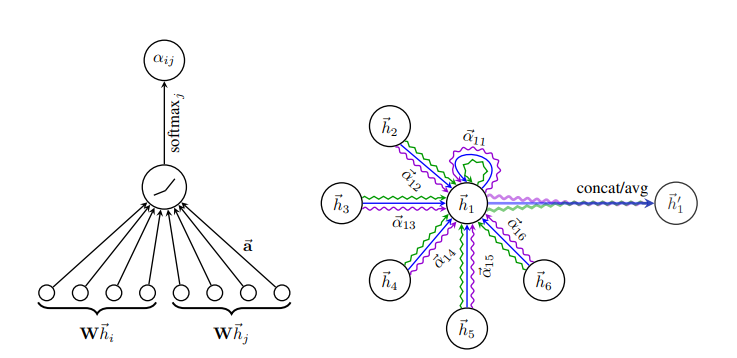

<em style="text-align:center" > Figure 2: **Left**: The attention mechanism $a(\textbf{W}\textbf{h}_i, \textbf{W}\textbf{h}_j)$ employed by the model, parametrized by a weight vector $\textbf{a}$, applying a $\text{LeakyReLU}$ activation. **Right**: An illustration of multihead attention (with K = 3 heads) by node 1 on its neighborhood. Different arrow styles and colors denote independent attention computations. The aggregated features from each head are
concatenated or averaged to obtain $\textbf{h}^{\prime}_1$

Figure Credit: [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903)
</em>

**Remark:**
If we're doing multi-head attention with $K$ heads, the message passing formula is instead:

$$\mathbf{h}^{\prime}_i = \underset{k=1}{\overset{K}{\big\Vert}}\sigma\left(\sum_{j \in \mathcal{N}(i)}
        \alpha^k_{i,j}\mathbf{W}^k\mathbf{h}_{j}\right)
$$
Where $(\alpha^k_{i,j})_{i,j \in \mathcal{V}}$ and $\mathbf{W^k}$ are attention coefficients and weight matrix for head $k$. The former being computed similarly as above. We simply concatenate the representations computed by various attention heads.

**📝TODO**: Fill the code below to complete the GAT module implementation.  
**❗NB:** Do not to apply the $\sigma$ activation as this will be done in the network.


In [87]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_heads: int = 1):
        super().__init__()
        self.num_heads = num_heads
        self.W = nn.Parameter(torch.randn(in_channels, out_channels))
        self.a = nn.Parameter(torch.randn(2 * out_channels, num_heads))
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        self.out_channels = out_channels

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        V = x.size(0)

        # Get adjacency matrix
        A = make_adjacency_matrix(V, edge_index)

        # Apply linear transformation to node features
        h =  x @ self.W  # h: (V, d')

        ### YOUR CODE HERE #######################
        # Add self-loops
        A += torch.eye(n = V)

        # Compute         self.linear = nn.Linear(in_)attention coefficients
        h_repeat_src = h.repeat(1, V).view(V, V, -1) # (V, V, d)
        h_repeat_dst = h.repeat(V, 1).view(V, V, -1) # (V, V, d)

        # Concatenate features of source and destination nodes
        h_concat = torch.cat([h_repeat_src, h_repeat_dst], dim=-1)  # h_concat: (V, V, 2 * d')

        # Compute attention scores
        e = h_concat @ self.a  # e: (V, V, num_heads)
        # Apply Leaky ReLu
        e = self.leakyrelu(e)

        # Mask out non-existent edges by setting the corresponding attention scores to -inf
        e = e.masked_fill(A.unsqueeze(-1) == 0, -9e16)

        # Apply softmax to compute attention coefficients
        alpha = e.softmax(-1)  # alpha: (V, V, num_heads)

        # Perform message passing
        # Weighted sum of neighboring features #  (V, H, out_features)
        H = torch.einsum("aab,ac -> abc",alpha, h)


        # Combine attention heads by concatenating
        H = H.view(V, -1) # H: (V, H*out_features)
        ############################################

        return H

**📝TODO**: Verify the correctness of your GAT module by comparing its output on a the below input to the expected output.

In [88]:
# Check that GAT output is as expected.
torch.manual_seed(42)
gat = GAT(in_channels=3, out_channels=2, num_heads=4)

# x: (V, d) - Example with 5 nodes and 3-dimensional features
x = torch.rand(5, 3)

# edge_index: (2, E) - Example edges with 4 edges
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])

# H: (V, d') - Output node features matrix after GAT operation
H = gat(x, edge_index)

# Expected output:
# Shape: (B=5, 8=2*4=out_channels*num_heads)
# Value: Tensor([
#  [-0.6249,  0.0123, -0.5971,  0.0250, -0.6327,  0.0088, -0.6689, -0.0077],
#  [-0.5225,  0.0526, -0.5014,  0.0618, -0.5300,  0.0494, -0.5697,  0.0321],
#  [-0.1674,  0.1469, -0.2094,  0.1405, -0.2003,  0.1419, -0.2681,  0.1314],
#  [-0.1829,  0.1303, -0.2417,  0.1173, -0.2394,  0.1180, -0.2950,  0.1051],
#  [-0.1363,  0.1304, -0.1640,  0.1230, -0.1547,  0.1255, -0.2611,  0.0970]],
# ])
print(H)

tensor([[-0.1383, -0.0165, -0.3423, -0.0409, -0.1648, -0.0197, -0.2373, -0.0283],
        [-0.0806,  0.0201, -0.1354,  0.0337, -0.0803,  0.0200, -0.1255,  0.0313],
        [-0.0686,  0.0242, -0.1070,  0.0378, -0.0670,  0.0237, -0.1029,  0.0364],
        [ 0.0169,  0.0611,  0.0108,  0.0391,  0.0099,  0.0356,  0.0124,  0.0446],
        [-0.0937,  0.0063, -0.1647,  0.0110, -0.0983,  0.0066, -0.1420,  0.0095]],
       grad_fn=<ViewBackward0>)


## Task 3: Efficient GCN implementation with PyTorch Geometric utilities.

**📝TODO:** Examine the GCN efficient implementation below and compare with your own implementations above and note how the main difference is its use of sparse matrix operations.

In [89]:
import torch

from torch_geometric.nn import GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import scatter, spmm, softmax

class GCNConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = torch.nn.Parameter(torch.randn(in_channels, out_channels))

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
          num_nodes = x.size(0)
          edge_index, _ = add_remaining_self_loops(edge_index)
          ### Take a look here. ################
          edge_weight = torch.ones((edge_index.size(1),), dtype=x.dtype, device=edge_index.device)
          source_idx, target_idx = edge_index[0], edge_index[1]
          deg = scatter(edge_weight, target_idx, dim=0, dim_size=num_nodes, reduce='sum')
          deg_inv_sqrt = deg.diag().pow_(-.5).diag()
          edge_weight = deg_inv_sqrt[source_idx] * edge_weight * deg_inv_sqrt[target_idx]
          x = x @ self.W
          #############################################
          out = self.propagate(edge_index, x=x, edge_weight=edge_weight)
          return out

    def message_and_aggregate(self, adj_t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return spmm(adj_t, x, reduce='add')

In [90]:
import torch

class Net(torch.nn.Module):
    def __init__(
        self,
        layers: list[torch.nn.Module],
        out_channels: int,
        activation = torch.nn.functional.sigmoid,
      ):
        super().__init__()
        torch.manual_seed(1234)
        self._layers = torch.nn.ModuleList(layers)
        self._classifier = torch.nn.Linear(self._layers[-1].out_channels, out_channels)

    def forward(self, x, edge_index):
        # Apply all but last layer followed by activation.
        h = x
        for layer in self._layers[:-1]:
          h = layer(h, edge_index)
          h = torch.sigmoid(h)
        # Apply last layer.
        h = self._layers[-1](h, edge_index)
        # Apply a final (linear) classifier.
        out = self._classifier(h)
        return out

## Task 4: Node classification on the Cora dataset.



**📝TODOS**
1. Read through the cora dataset overview.
2. Read through the training & evalution script.
3. Fill in the code to complete the MLP, GCN and GAT networks.
4. Run the training and evalution script and visualize the learning curve (training loss) and evaluation accuracy.

### Cora dataset Overview.
The Cora dataset is a citation network of 2,708 machine-learning papers, organized into seven distinct classes. These papers are interlinked by 5,429 citations, forming a directed graph that maps out how papers cite each other. Each paper is represented by a binary word vector, derived from a dictionary of 1,433 unique words, indicating the presence or absence of specific words in the paper.

#### Features and Labels
Each paper in the Cora dataset is described by a binary word vector, which serves as the feature set for the dataset. The presence (1) or absence (0) of each word from a dictionary of 1,433 unique words is recorded in this vector. This high-dimensional feature space captures the content of each paper, enabling detailed analysis and classification.

The labels in the Cora dataset correspond to the seven classes of machine learning topics:

- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory


These labels provide a categorical classification for each paper, which is used as the target variable in various machine learning tasks.

### How Graphs are represented in Pytorch Geometric.

We will be loading the Cora datasets from Pytorch Geometric's `datasets` subpackage.

A Pytorch Geometric Dataset consist of a list `torch_geometric.data.Data` objects, each representing a Graph, and holding the following attributes by default:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`



- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

None of these attributes are required. In fact, the Data object is not even restricted to these attributes. You can read more [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#data-handling-of-graphs).

### Loading the Cora Dataset from Pytorch Geometric.

In [91]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

data = dataset[0]
print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.052
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


### Training & Evaluation

In [92]:
import dataclasses
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm


@dataclasses.dataclass(frozen=True)
class StepRecord:
  step: int
  train_loss: float
  eval_acc: float | None

  def to_dict(self) -> dict:
    return dataclasses.asdict(self)

def train(
    model: torch.nn.Module,
    data,
    num_steps: int,
    lr: float,
    weight_decay: float,
  ) -> list[StepRecord]:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = torch.nn.CrossEntropyLoss()

  # Evaluation function.
  def eval() -> float:
      """Returns accuracy."""
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
      accuracy = correct / data.test_mask.sum()
      return accuracy.item()


  # Train function.
  def train_step() -> float:
      """Optimization step returns loss."""
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss.item()

  # Training & Evaluation loop.
  step_records = []
  for step in tqdm(range(1, num_steps+1)):
      train_loss = train_step()
      eval_acc = eval()
      step_record = StepRecord(
        step=step,
        train_loss=train_loss,
        eval_acc=eval_acc,
      )
      step_records.append(step_record)

  return step_records

In [93]:
# Linear layer with pyg interface.
class Linear(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.out_channels = out_channels
      self.weight = torch.nn.Parameter(torch.randn(in_channels, out_channels))

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        del edge_index
        return x @ self.weight

In [94]:
# Define the networks, train & evaluate them.
mlp = Net(
    layers=[
        Linear(1433, 4),
        Linear(4, 4),
    ],
    out_channels=7,
)
gcn = Net(
    layers=[
        GCNConv(1433, 4),
        GCNConv(4, 4),
    ],
    out_channels=7,
)
gat = Net(
    layers=[
        GATConv(1433, 4, heads=1),
        GATConv(4, 4, heads=1),
    ],
    out_channels=7,
)
mlp_step_records = train(mlp, dataset[0], 400, 0.01, 5e-4)
gcn_step_records = train(gcn, dataset[0], 400, 0.01, 5e-4)
gat_step_records = train(gat, dataset[0], 400, 0.01, 5e-4)

100%|██████████| 400/400 [00:03<00:00, 121.79it/s]


<Axes: title={'center': 'Evaluation Accuracy'}, xlabel='step'>

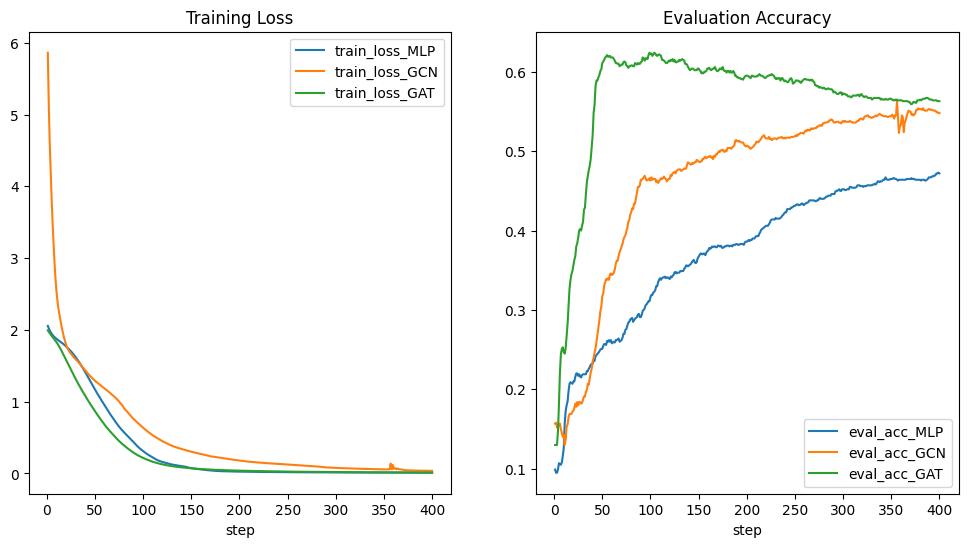

In [95]:
# Plot results.
mlp_step_df = pd.DataFrame([sr.to_dict() for sr in mlp_step_records]).set_index('step')
gcn_step_df = pd.DataFrame([sr.to_dict() for sr in gcn_step_records]).set_index('step')
gat_step_df = pd.DataFrame([sr.to_dict() for sr in gat_step_records]).set_index('step')

mlp_step_df.rename(columns=lambda colname: f'{colname}_MLP', inplace=True)
gcn_step_df.rename(columns=lambda colname: f'{colname}_GCN', inplace=True)
gat_step_df.rename(columns=lambda colname: f'{colname}_GAT', inplace=True)

step_df = gcn_step_df.merge(
    gat_step_df,
    on='step',
    how='inner'
).merge(
    mlp_step_df,
    on='step',
    how='inner'
)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
step_df.plot(use_index=True, y=['train_loss_MLP', 'train_loss_GCN', 'train_loss_GAT'], title='Training Loss', ax=axes[0])
step_df.plot(use_index=True, y=['eval_acc_MLP', 'eval_acc_GCN', 'eval_acc_GAT'], title='Evaluation Accuracy', ax=axes[1])

### Analysis
**📝TODO**
1. Using the default parameters how does the MLP perform compared to GCN and GAT? Answer both in terms of training loss and evaluation accuracy.
2. Why do you think the MLP is substantially worse ?
3. [Optional] How does the number of attention heads used in GAT affect the training loss and evaluation accuracy? Give two plausible explanations?